라이브러리

In [1]:
import pandas as pd
import numpy as np
from keras.utils import *
from sklearn.preprocessing import *
from keras import backend as K
from keras.models import load_model
from keras.layers import LSTM, Dense, Attention, Input
from keras.models import Model
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.font_manager as fm
from matplotlib.dates import DateFormatter
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# 모델명(= 파일명) 설정
tank = 1
model_name = 'rereredoRegressor_tank1food2'

In [2]:
# r_squared 평가 함수
def r_squared(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - ss_res/(ss_tot + K.epsilon()))

데이터셋 설정

In [3]:
#자포니카 훈련 데이터
japonica_training_food_supply_tb = pd.read_csv("eeldata/data/Training/Origin/Management/Japonica/food_supply_tb.csv")
japonica_training_sensor_val_tb = pd.read_csv("eeldata/data/Training/Origin/Sensor/Japonica/sensor_val_tb.csv")

#자포니카 검증 데이터
japonica_validation_food_supply_tb = pd.read_csv("eeldata/data/Validation/Origin/Management/Japonica/food_supply_tb.csv")
japonica_validation_sensor_val_tb = pd.read_csv("eeldata/data/Validation/Origin/Sensor/Japonica/sensor_val_tb.csv")


In [4]:
# 자포니카 사료 공급 데이터 정제
# null제거
japonica_training_food_supply_tb = japonica_training_food_supply_tb[japonica_training_food_supply_tb['feed_quantity'].notnull()]
japonica_validation_food_supply_tb = japonica_validation_food_supply_tb[japonica_validation_food_supply_tb['feed_quantity'].notnull()]

# 시계열 데이터 변환
japonica_training_food_supply_tb['feed_dt'] = pd.to_datetime(japonica_training_food_supply_tb['feed_dt'], format='%Y%m%d%H%M', errors='raise')
japonica_training_food_supply_tb["feed_dt"] = japonica_training_food_supply_tb["feed_dt"].apply(str)
japonica_training_food_supply_tb["feed_dt"] = japonica_training_food_supply_tb["feed_dt"].str.slice(start=0, stop=16)
japonica_validation_food_supply_tb['feed_dt'] = pd.to_datetime(japonica_validation_food_supply_tb['feed_dt'], format='%Y%m%d%H%M', errors='raise')
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].apply(str)
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].str.slice(start=0, stop=16)

In [5]:
# 자포니카 센서 데이터 정제

# 한 개 탱크
japonica_training_sensor_val_tb = japonica_training_sensor_val_tb[japonica_training_sensor_val_tb['tank_id']==tank]
japonica_validation_sensor_val_tb = japonica_validation_sensor_val_tb[japonica_validation_sensor_val_tb['tank_id']==tank]

#시계열 변환
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].apply(str)
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_training_sensor_val_tb['mea_dt'] = pd.to_datetime(japonica_training_sensor_val_tb['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].apply(str)
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_validation_sensor_val_tb['mea_dt'] = pd.to_datetime(japonica_validation_sensor_val_tb['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')

# 시계열 데이터의 개수 확인
training_counts = japonica_training_sensor_val_tb.groupby(japonica_training_sensor_val_tb['mea_dt'].dt.date).size()
validation_counts = japonica_validation_sensor_val_tb.groupby(japonica_validation_sensor_val_tb['mea_dt'].dt.date).size()

# 개수가 1440이 아닌 시계열 삭제
to_delete = training_counts[training_counts != 1440].index
japonica_training_sensor_val_tb = japonica_training_sensor_val_tb[~japonica_training_sensor_val_tb['mea_dt'].dt.date.isin(to_delete)]
to_delete = validation_counts[validation_counts != 1440].index
japonica_validation_sensor_val_tb = japonica_validation_sensor_val_tb[~japonica_validation_sensor_val_tb['mea_dt'].dt.date.isin(to_delete)]

#시계열 데이터 문자 타입으로 변경
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].dt.strftime('%Y-%m-%d %H:%M')
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].dt.strftime('%Y-%m-%d %H:%M')
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)


In [6]:
# 자포니카 훈련 데이터 및 시계열 데이터 병합
japonica_training = pd.merge(left = japonica_training_sensor_val_tb, right = japonica_training_food_supply_tb, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])
japonica_validation = pd.merge(left = japonica_validation_sensor_val_tb, right = japonica_validation_food_supply_tb, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])

japonica_training['mea_dt'] = pd.to_datetime(japonica_training['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')
japonica_validation['mea_dt'] = pd.to_datetime(japonica_validation['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')

# 사용할 features 선택
feature_origin = ['tank_id','mea_dt', 'do_mg','do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']
japonica_training_features = japonica_training[feature_origin]
japonica_validation_features = japonica_validation[feature_origin]

# nan 값 처리 (먹이를 주지 않았을 경우는 급여량이 0이니까)
japonica_training_features = japonica_training_features.fillna(0)
japonica_validation_features = japonica_validation_features.fillna(0)

# 날짜 데이터를 인덱스로 전환
japonica_training_features.set_index('mea_dt', inplace=True)
japonica_validation_features.set_index('mea_dt', inplace=True)

# 인덱스 순으로 데이터를 정렬
japonica_training_data = japonica_training_features.sort_index()
japonica_validation_data = japonica_validation_features.sort_index()

# 8월 1달간 데이터만 추출
japonica_training_data = japonica_training_data.loc['2021-07-21 00:00':'2021-09-08 23:59']
japonica_validation_data = japonica_validation_data.loc['2021-07-21 00:00':'2021-09-08 23:59']

In [7]:
time_ranges = [('03:00:00', '05:59:00'), ('15:00:00', '17:59:00')]

japonica_training_data_feed = []
japonica_validation_data_feed = []

for time_range in time_ranges:
    start_time, end_time = time_range
    japonica_training_data_feed.append(japonica_training_data.between_time(start_time, end_time))
    japonica_validation_data_feed.append(japonica_validation_data.between_time(start_time, end_time))
    

japonica_training_data = pd.concat(japonica_training_data_feed)
japonica_validation_data = pd.concat(japonica_validation_data_feed)

In [8]:
japonica_training_data

,tank_id,do_mg,do_temp,ph,orp,co2_mg,air_oxy,light_ma,feed_quantity,water_quantity
mea_dt,,,,,,,,,,
2021-07-21 03:00:00,1,8.1,30.2,5.27,213.6,11.9,0.0,4.0,0.0,0.0
2021-07-21 03:01:00,1,8.1,30.2,5.27,213.3,11.9,0.0,3.9,0.0,0.0
2021-07-21 03:02:00,1,8.2,30.2,5.27,213.4,11.9,0.0,4.1,0.0,0.0
2021-07-21 03:03:00,1,8.2,30.2,5.27,213.4,11.9,0.0,4.0,0.0,0.0
2021-07-21 03:04:00,1,8.2,30.2,5.27,213.5,11.8,0.0,3.9,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2021-09-08 17:55:00,1,8.1,28.9,5.42,156.1,32.1,0.0,3.9,0.0,0.0
2021-09-08 17:56:00,1,8.2,28.9,5.42,156.2,31.9,0.0,4.0,0.0,0.0
2021-09-08 17:57:00,1,8.3,28.9,5.42,156.2,31.9,0.0,4.0,0.0,0.0


In [9]:
japonica_training_features_X = japonica_training_data[['feed_quantity']]

japonica_validation_features_X = japonica_validation_data[['feed_quantity']]

In [10]:
japonica_training_features_y = japonica_training_data[['do_mg']]

japonica_validation_features_y = japonica_validation_data[['do_mg']]

In [11]:
japonica_training_features_X = japonica_training_features_X.drop(japonica_training_features_X.index[-2:])
japonica_training_features_X_chunks = np.asarray(japonica_training_features_X, dtype=np.float64)
japonica_training_features_X_chunks = japonica_training_features_X_chunks.reshape((-1, 180, 1))

japonica_training_features_y = japonica_training_features_y.drop(japonica_training_features_y.index[-2:])
japonica_training_features_y_chunks = np.asarray(japonica_training_features_y, dtype=np.float64)
japonica_training_features_y_chunks = japonica_training_features_y_chunks.reshape((-1, 180, 1))

japonica_validation_features_X = japonica_validation_features_X.drop(japonica_validation_features_X.index[-2:])
japonica_validation_features_X_chunks = np.asarray(japonica_validation_features_X, dtype=np.float64)
japonica_validation_features_X_chunks = japonica_validation_features_X_chunks.reshape((-1, 180, 1))

japonica_validation_features_y = japonica_validation_features_y.drop(japonica_validation_features_y.index[-2:])
japonica_validation_features_y_chunks = np.asarray(japonica_validation_features_y, dtype=np.float64)
japonica_validation_features_y_chunks = japonica_validation_features_y_chunks.reshape((-1, 180, 1))

In [12]:
# shape확인
nCar = japonica_training_features_X_chunks.shape[0] # 데이터 개수
nVar = japonica_training_features_X_chunks.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_training_features_y_chunks.shape[0] # 데이터 개수
nVar = japonica_training_features_y_chunks.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_X_chunks.shape[0] # 데이터 개수
nVar = japonica_validation_features_X_chunks.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_y_chunks.shape[0] # 데이터 개수
nVar = japonica_validation_features_y_chunks.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 90 nVar: 1
nCar: 90 nVar: 180
nCar: 90 nVar: 1
nCar: 90 nVar: 180


LSTM 모델 학습 (학습시에만 사용, 그외에는 불필요)

In [13]:
# LSTM 모델 생성
model = Sequential()
# 결과값이 128개 -> 64개 -> 32개 -> 1개(회귀)
# input_shape=(timesteps, input_dim)
# timesteps : 시계열 데이터의 시간 스텝 수.
#       예를 들어, 1분 단위로 측정한 센서 데이터가 있다면 timesteps는 60.
# input_dim : 특성(feature)의 수.
model.add(LSTM(128, input_shape=(180, 1), return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(180, activation='linear'))
 
model.summary()

# mae와 r_squared 평가함수 추가.
model.compile(optimizer='adam', loss='mse', metrics=['mae', r_squared])


checkpoint = ModelCheckpoint(model_name + '_best.h5', monitor='val_loss', save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

# ModelCheckpoint : 검증 손실이 낮아진 경우에 최적의 모델을 저장
# EarlyStopping : 검증 손실이 일정 기간동안 향상되지 않으면 학습을 조기 종료
# ReduceLROnPlateau : 검증 손실이 개선되지 않으면 학습률을 조정하는 등의 동작 수행.


hist = model.fit(japonica_training_features_X_chunks, japonica_training_features_y_chunks, epochs = 200, batch_size = 32, validation_data=(japonica_validation_features_X_chunks, japonica_validation_features_y_chunks), callbacks=[checkpoint, early_stop, reduce_lr])
model.save(model_name+'.h5')

2023-07-12 11:47:24.140905: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-12 11:47:24.763542: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7951 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe MIG 1g.10gb, pci bus id: 0000:d5:00.0, compute capability: 8.0


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 180, 128)          66560     
_________________________________________________________________
lstm_1 (LSTM)                (None, 180, 64)           49408     
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense (Dense)                (None, 180)               5940      
Total params: 134,324
Trainable params: 134,324
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200


2023-07-12 11:47:25.849685: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-07-12 11:47:30.123469: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8200
2023-07-12 11:47:31.101673: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


3/3 [==============================] - 7s 569ms/step - loss: 74.6167 - mae: 8.5505 - r_squared: -53.1587 - val_loss: 74.5212 - val_mae: 8.5449 - val_r_squared: -49.1911
Epoch 2/200
3/3 [==============================] - 0s 68ms/step - loss: 74.4323 - mae: 8.5396 - r_squared: -49.7038 - val_loss: 74.0958 - val_mae: 8.5198 - val_r_squared: -48.9047
Epoch 3/200
3/3 [==============================] - 0s 69ms/step - loss: 73.6988 - mae: 8.4960 - r_squared: -51.1587 - val_loss: 72.4239 - val_mae: 8.4188 - val_r_squared: -47.7788
Epoch 4/200
3/3 [==============================] - 0s 72ms/step - loss: 71.9170 - mae: 8.3881 - r_squared: -52.8218 - val_loss: 70.8553 - val_mae: 8.3234 - val_r_squared: -46.7225
Epoch 5/200
3/3 [==============================] - 0s 73ms/step - loss: 70.3898 - mae: 8.2951 - r_squared: -47.4152 - val_loss: 69.3426 - val_mae: 8.2302 - val_r_squared: -45.7038
Epoch 6/200
3/3 [==============================] - 0s 74ms/step - loss: 68.8289 - mae: 8.1982 - r_squared: -45.

3/3 [==============================] - 0s 85ms/step - loss: 3.5075 - mae: 1.5743 - r_squared: -1.4449 - val_loss: 3.4353 - val_mae: 1.5554 - val_r_squared: -1.3134
Epoch 93/200
3/3 [==============================] - 0s 87ms/step - loss: 3.4026 - mae: 1.5469 - r_squared: -1.4040 - val_loss: 3.3380 - val_mae: 1.5292 - val_r_squared: -1.2478
Epoch 94/200
3/3 [==============================] - 0s 85ms/step - loss: 3.3089 - mae: 1.5218 - r_squared: -1.4561 - val_loss: 3.2440 - val_mae: 1.5035 - val_r_squared: -1.1844
Epoch 95/200
3/3 [==============================] - 0s 99ms/step - loss: 3.2191 - mae: 1.4961 - r_squared: -1.2170 - val_loss: 3.1534 - val_mae: 1.4786 - val_r_squared: -1.1233
Epoch 96/200
3/3 [==============================] - 0s 88ms/step - loss: 3.1267 - mae: 1.4720 - r_squared: -1.2812 - val_loss: 3.0679 - val_mae: 1.4548 - val_r_squared: -1.0657
Epoch 97/200
3/3 [==============================] - 0s 85ms/step - loss: 3.0419 - mae: 1.4479 - r_squared: -1.1724 - val_loss: 2

3/3 [==============================] - 0s 73ms/step - loss: 1.4368 - mae: 0.9054 - r_squared: 0.0466 - val_loss: 1.4364 - val_mae: 0.9053 - val_r_squared: 0.0356
Epoch 185/200
3/3 [==============================] - 0s 86ms/step - loss: 1.4363 - mae: 0.9052 - r_squared: 0.0497 - val_loss: 1.4360 - val_mae: 0.9051 - val_r_squared: 0.0359
Epoch 186/200
3/3 [==============================] - 0s 75ms/step - loss: 1.4360 - mae: 0.9050 - r_squared: 0.0331 - val_loss: 1.4355 - val_mae: 0.9049 - val_r_squared: 0.0362
Epoch 187/200
3/3 [==============================] - 0s 77ms/step - loss: 1.4353 - mae: 0.9048 - r_squared: 0.0378 - val_loss: 1.4352 - val_mae: 0.9047 - val_r_squared: 0.0365
Epoch 188/200
3/3 [==============================] - 0s 87ms/step - loss: 1.4354 - mae: 0.9048 - r_squared: -0.0102 - val_loss: 1.4347 - val_mae: 0.9045 - val_r_squared: 0.0368
Epoch 189/200
3/3 [==============================] - 0s 91ms/step - loss: 1.4346 - mae: 0.9045 - r_squared: 0.0379 - val_loss: 1.4344

모델 평가

In [18]:
# 모델 평가 함수
def grapeNEva(model, X_test_shape, y_test, feed, y_test_shape):
    X_pred = model.predict(X_test_shape)
    X_pred = np.asarray(X_pred, dtype=np.float64)
    X_pred = X_pred.reshape((-1))
    print(len(X_pred))

    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test, label='sensor do')  # x축에 년월일, y축에 값
    plt.plot(y_test.index, X_pred, color='red', label='prediction do')  # x축에 년월일, y축에 시분
    plt.plot(y_test.index, feed, color='green', marker='o', linestyle='None', label='feed_quantity')  # x축에 년월일, y축에 시분
    plt.xlabel('date')
    plt.ylabel('do')
    plt.title(model_name)
    plt.legend(['sensor do','prediction do','feed_quantity'])
    plt.show()
    
    # 평가 생성
    result = model.evaluate(X_test_shape, y_test_shape)
    print("MSE // MAE // R-squared ", result)

In [19]:
# r_squared가 따로 만들어서 추가해준 함수기 때문에 불러올 때도 추가해서 불러야한다.
model = load_model(model_name+'.h5', custom_objects={'r_squared': r_squared})

[[-0.00239172 -0.00058349 -0.02812448  0.07091655  0.1074665   0.08045389
  -0.10002962 -0.03365917 -0.09738345  0.00304064 -0.04047244  0.0959009
   0.04631536  0.03452538  0.06742638  0.10728092 -0.07804145 -0.00349766
   0.11187184 -0.03242777 -0.05575452 -0.03668524  0.11069091 -0.11188815
   0.06008299  0.08908947 -0.08471179  0.07761195  0.0858778  -0.04919714
   0.10257259  0.0757065   0.08605187 -0.10949313 -0.09398876  0.10498003
  -0.05031788 -0.0848925  -0.03250956 -0.11430901  0.01453594  0.06608626
   0.06793401 -0.06879332 -0.01963143  0.01610179 -0.00616895 -0.04836112
  -0.0357693  -0.04447958  0.00371602  0.07411768 -0.06675715  0.10094827
   0.00976233  0.00265858 -0.0407481  -0.01389273  0.02380856 -0.00333749
   0.02607596  0.08776784  0.08136757 -0.0720283   0.00254578 -0.01671622
   0.01305076  0.06609235 -0.03702784 -0.0458372   0.02193542  0.04167626
   0.00498799  0.07103983 -0.08491049 -0.04953735 -0.08006886  0.05753247
   0.04783101 -0.08475167  0.08576363 -

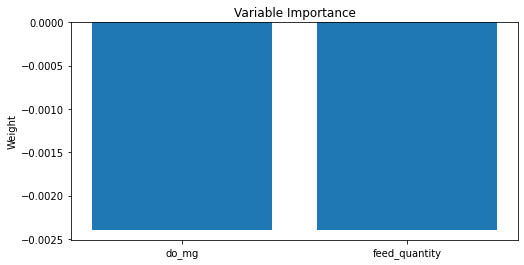

In [20]:
# 가중치를 통해 변수 중요도 획득
weights = model.layers[0].get_weights()[0]
print(weights)


# 변수 중요도 시각화
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(range(2), weights[:, 0])
ax.set_xticks(range(2))
ax.set_xticklabels(['do_mg', 'feed_quantity'])
ax.set_ylabel('Weight')
ax.set_title('Variable Importance')
plt.show()

In [44]:
X = japonica_validation_features.sort_index().loc['2021-07-21 00:00':'2021-09-08 23:59']
X_test = X[['feed_quantity']]

X_test_reshape = np.asarray(X_test, dtype=np.float64)
X_test_reshape = X_test_reshape.reshape((-1, 180, 1))

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 360 nVar: 1


In [45]:
y_test = X[['do_mg']]


y_test_reshape = np.asarray(y_test, dtype=np.float64)
y_test_reshape = y_test_reshape.reshape((-1, 180, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 64800 nVar: 1
nCar: 360 nVar: 180


64800


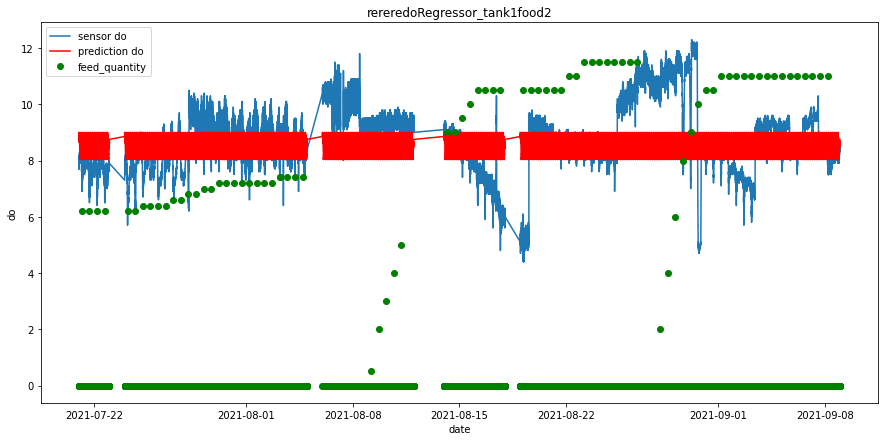

12/12 [==============================] - 0s 16ms/step - loss: 1.5775 - mae: 0.9417 - r_squared: -1.2170
MSE // MAE // R-squared  [1.577520728111267, 0.9416958093643188, -1.2169891595840454]


In [46]:
grapeNEva(model, X_test_reshape, y_test, X_test[['feed_quantity']], y_test_reshape)

In [47]:
X = japonica_validation_features.sort_index().loc['2021-07-21 00:00':'2021-07-31 23:59']
X_test = X[['feed_quantity']]

X_test_reshape = np.asarray(X_test, dtype=np.float64)
X_test_reshape = X_test_reshape.reshape((-1, 180, 1))

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 80 nVar: 1


In [48]:
y_test = X[['do_mg']]


y_test_reshape = np.asarray(y_test, dtype=np.float64)
y_test_reshape = y_test_reshape.reshape((-1, 180, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 14400 nVar: 1
nCar: 80 nVar: 180


14400


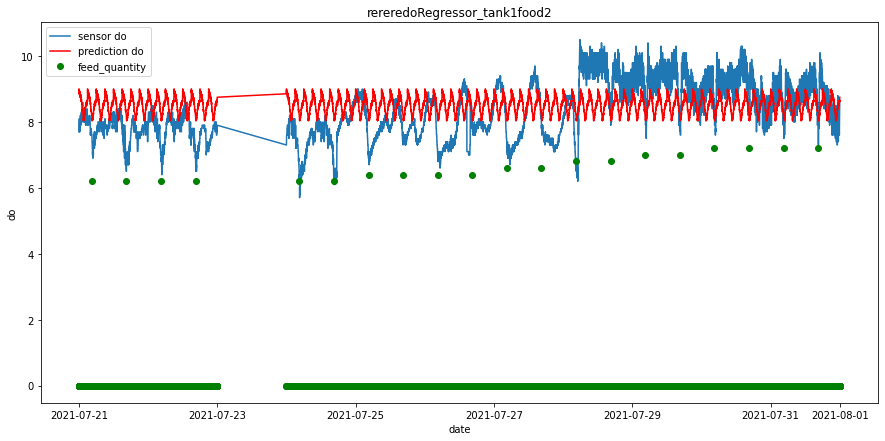

3/3 [==============================] - 0s 17ms/step - loss: 0.7947 - mae: 0.7506 - r_squared: -1.0381
MSE // MAE // R-squared  [0.7947414517402649, 0.750623881816864, -1.0380606651306152]


In [49]:
grapeNEva(model, X_test_reshape, y_test, X_test[['feed_quantity']], y_test_reshape)

In [50]:
X = japonica_validation_features.sort_index().loc['2021-07-21 00:00':'2021-07-21 23:59']
X_test = X[['feed_quantity']]

X_test_reshape = np.asarray(X_test, dtype=np.float64)
X_test_reshape = X_test_reshape.reshape((-1, 180, 1))

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 8 nVar: 1


In [51]:
y_test = X[['do_mg']]


y_test_reshape = np.asarray(y_test, dtype=np.float64)
y_test_reshape = y_test_reshape.reshape((-1, 180, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 1440 nVar: 1
nCar: 8 nVar: 180


1440


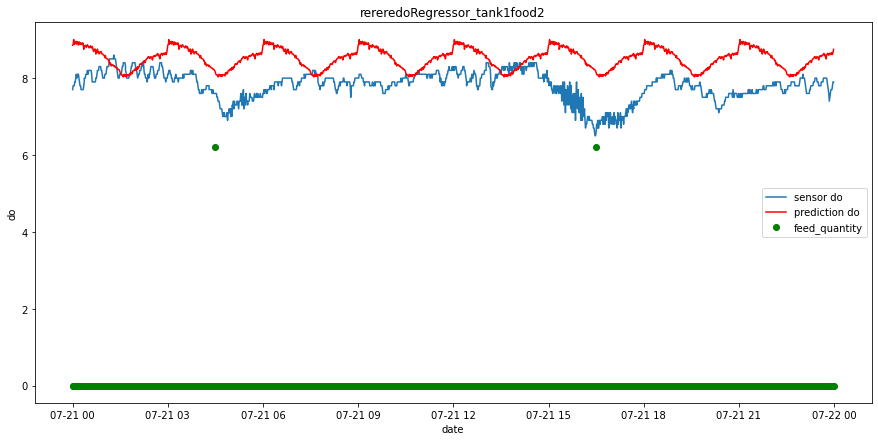

1/1 [==============================] - 0s 61ms/step - loss: 0.6811 - mae: 0.7205 - r_squared: -3.9566
MSE // MAE // R-squared  [0.6810528039932251, 0.7205439209938049, -3.9566025733947754]


In [52]:
grapeNEva(model, X_test_reshape, y_test, X_test[['feed_quantity']], y_test_reshape)

In [55]:
X = japonica_validation_features.sort_index().loc['2021-07-21 04:30':'2021-07-21 16:29']
X_test = X[['feed_quantity']]

X_test_reshape = np.asarray(X_test, dtype=np.float64)
X_test_reshape = X_test_reshape.reshape((-1, 180, 1))

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 4 nVar: 1


In [56]:
y_test = X[['do_mg']]


y_test_reshape = np.asarray(y_test, dtype=np.float64)
y_test_reshape = y_test_reshape.reshape((-1, 180, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 720 nVar: 1
nCar: 4 nVar: 180


720


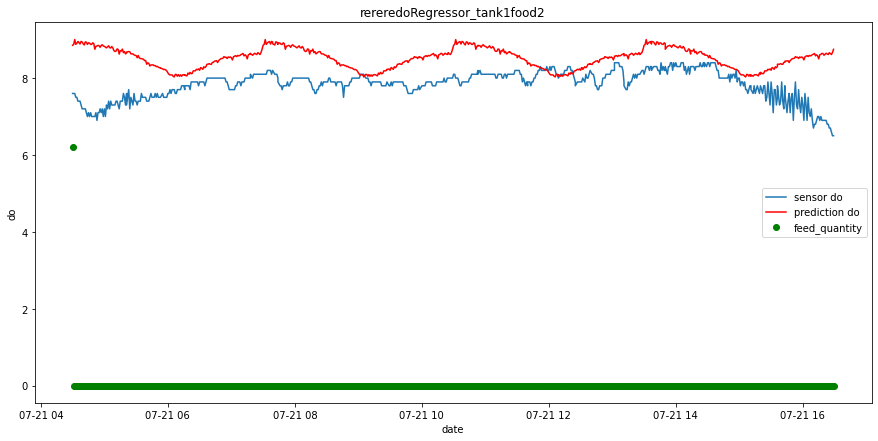

1/1 [==============================] - 0s 43ms/step - loss: 0.6547 - mae: 0.6799 - r_squared: -4.0428
MSE // MAE // R-squared  [0.654698371887207, 0.6798949837684631, -4.042786598205566]


In [58]:
grapeNEva(model, X_test_reshape, y_test, X_test[['feed_quantity']], y_test_reshape)